# CPU to GPU

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [10]:
torch.cuda.is_available()

True

In [2]:
device = torch.device('cuda')

In [11]:
print(device)

cuda


In [6]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

0.00B [00:00, ?B/s]

26.4MB [00:04, 5.35MB/s]                            


Extracting /home/thom/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz


0.00B [00:00, ?B/s]

32.8kB [00:00, 90.3kB/s]                           
0.00B [00:00, ?B/s]

Extracting /home/thom/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4.42MB [00:01, 3.09MB/s]                            
0.00B [00:00, ?B/s]

Extracting /home/thom/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8.19kB [00:00, 31.9kB/s]                   

Extracting /home/thom/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [12]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [13]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
        images.to(device)
        labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

RuntimeError: Expected object of type torch.cuda.FloatTensor but found type torch.FloatTensor for argument #4 'mat1'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 


with torch.no_grad():
    logps = model(img)

In [8]:
ps = torch.exp(logps)
ps

tensor([[1.4787e-06, 5.1537e-07, 8.3431e-06, 8.7249e-07, 5.9432e-06, 1.8999e-01,
         4.7754e-06, 1.6158e-01, 4.3408e-03, 6.4407e-01]])

In [9]:
nps = ps.numpy()[0]
nps

array([1.4786539e-06, 5.1537421e-07, 8.3430768e-06, 8.7248571e-07,
       5.9432264e-06, 1.8999223e-01, 4.7754252e-06, 1.6157573e-01,
       4.3407539e-03, 6.4406937e-01], dtype=float32)

<BarContainer object of 10 artists>

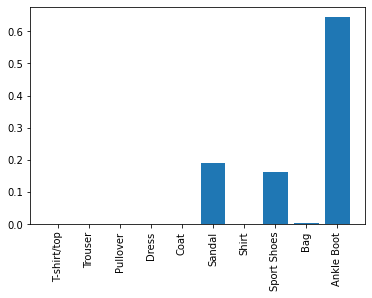

In [10]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

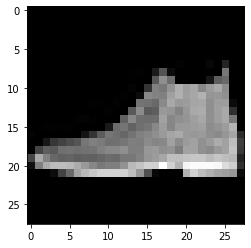

In [11]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')